In [1]:
import matplotlib.pyplot as plt
import gzip
import numpy as np
import os
def load_data_gz(data_folder):
    files = ['train-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz']

    paths = []
    for fname in files:
        paths.append(os.path.join(data_folder, fname))

    # 读取每个文件夹的数据
    with gzip.open(paths[0], 'rb') as lbpath:
        y_train = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open(paths[1], 'rb') as imgpath:
        x_train = np.frombuffer(imgpath.read(), np.uint8, offset=16).reshape(len(y_train), 784)

    with gzip.open(paths[2], 'rb') as lbpath:
        y_test = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open(paths[3], 'rb') as imgpath:
        x_test = np.frombuffer(imgpath.read(), np.uint8, offset=16).reshape(len(y_test), 784)

    return x_train, y_train, x_test, y_test

# 调用load_data_gz函数加载数据集
data_folder = r'C:\Users\86181\Aconda\machine_learning\mnist_datasets'
x_train_gz, y_train_gz, x_test_gz, y_test_gz = load_data_gz(data_folder)

print('x_train_gz.shape:', x_train_gz.shape)
print('y_train_gz.shape', y_train_gz.shape)
print('x_test_gz.shape:', x_test_gz.shape)
print('y_test_gz.shape:', y_test_gz.shape)

x_train_gz.shape: (60000, 784)
y_train_gz.shape (60000,)
x_test_gz.shape: (10000, 784)
y_test_gz.shape: (10000,)


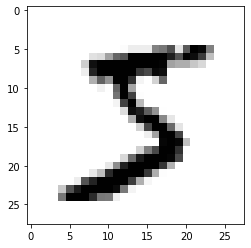

In [2]:
some_digit = x_train_gz[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("on")
plt.show()

In [3]:
#简化问题，只尝试识别一个数字

y_train_5 = (y_train_gz == 5)
y_test_5 = (y_test_gz == 5)

In [7]:
#  1.挑选一个合适的分类器，一个好的初始选择是随机梯队下降（SGD）分类器

#  使用scikit-learn的SGDClassifier类即可，这个分类器的优势是能够有效处理非常大的数据集

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(x_train_gz, y_train_5)

SGDClassifier(random_state=42)

In [5]:
sgd_clf.predict([some_digit])

array([ True])

In [6]:
#性能测量：评估分类器

#使用交叉验证测量准确率

#相比于scikit-learn的cross_val_score()交叉验证函数，你自己可以控制实现交叉验证

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

for train_index, test_index in skfolds.split(x_train_gz, y_train_5):
    clone_clf = clone(sgd_clf)
    x_train_folds = x_train_gz[train_index]
    y_train_folds = y_train_5[train_index]
    
    x_test_fold = x_train_gz[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(x_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [7]:
#用cross_val_score()函数来评估SGDClassifier模型,采用K折交叉验证法

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, x_train_gz, y_train_5, cv = 3, scoring ="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [8]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, x, y = None):
        return self
    def predict(self, x):
        return np.zeros((len(x), 1), dtype = bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, x_train_gz, y_train_5, cv = 3, scoring = "accuracy")

array([0.91125, 0.90855, 0.90915])

In [9]:
#只有大约10%的图片是数字5，所以如果你猜一张图片不是5，90%的概率你是正确的

#这说明准确率无法成为分类器的首要性能指标，特别是当你处理有偏数据集

sum(y_train_gz == 5)

5421

In [10]:
#评估分类器性能的更好方法是混淆矩阵

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, x_train_gz, y_train_5, cv = 3)

#给出目标类型y_train_5和预测类别y_train_pred，计算获得混淆矩阵

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

#混淆矩阵的行表示实际类别，列代表预测类别
#                  预测非5类别    预测5类别
#实际非5类别       53892           687
#实际5类别         1891           3530

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [11]:
# pretend we reached perfection

y_train_perfect_prediction = y_train_5

confusion_matrix(y_train_5, y_train_perfect_prediction)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [12]:
#    精度 = TP / (TP + FP)
#    召回率 = TP / (TP + FN)

from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))    # 3530 / (3530 + 687)

print(recall_score(y_train_5, y_train_pred))     # 3530 / (3530 + 1891)  


0.8370879772350012
0.6511713705958311


In [13]:
#将精度和召回率组成一个单一的指标

#F1分数是精度和召回率的谐波平均值，谐波平均值会给予低值更高的权重

from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [14]:
y_scores = sgd_clf.decision_function([some_digit])
print("y_scores:",y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print("y_some_digit_pred:",y_some_digit_pred)

y_scores: [2164.22030239]
y_some_digit_pred: [ True]


In [15]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [16]:
#cross_val_predict()函数用来获取训练集中所有实例的分数,返回的是决策分数而不是预测结果

y_scores = cross_val_predict(sgd_clf, x_train_gz, y_train_5, cv = 3, method = "decision_function")

In [29]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [44]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [17]:
#有了决策分数，可以使用precision_recall_curve()函数来计算所有可能的阙值的精度和召回率

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

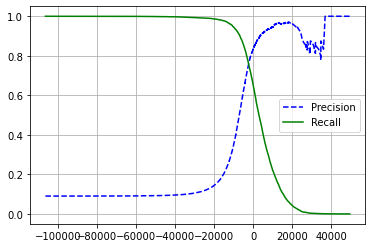

In [18]:
#绘制精度和召回率相对于阙值的函数图

def plot_precision_recall_vs_threshold(precision, recalls, thresholds):
    plt.plot(thresholds, precision[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.legend()
plt.grid()
plt.axis()
plt.show()

Text(0, 0.5, 'precisions')

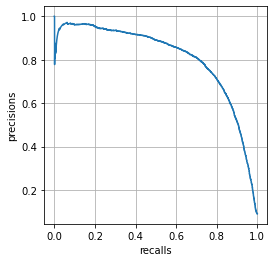

In [19]:
plt.figure(figsize=(4,4))
plt.plot(recalls, precisions, '-')
plt.grid(True)
plt.xlabel('recalls')
plt.ylabel('precisions')

In [22]:
print(np.argmax(precisions >= 0.9))
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
print(threshold_90_precision)

57075
3370.0194991439557


In [27]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90.shape

(60000,)

In [28]:
print('预测结果的精度',precision_score(y_train_5, y_train_pred_90))
print('预测结果的召回率',recall_score(y_train_5, y_train_pred_90))

预测结果的精度 0.9000345901072293
预测结果的召回率 0.4799852425751706


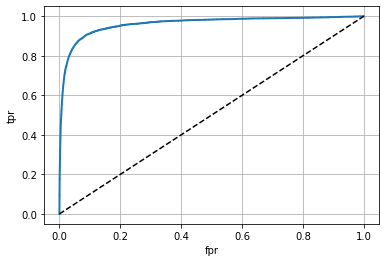

In [36]:
# ROC（受试者工作特征曲线），其绘制的是真正类率（召回率的另一名称）和假正类率（FPR）

# FPR是被错误分类为正类的负类实例的比率，它等于1 - 真负类率（TNR）,后者是被正确分类为负类的负类实例比率，也称特异度

#因此，ROC曲线绘制的是灵敏度（召回率）和（1 - 特异度）的关系

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

#绘制FPR（假正率）对TPR（召回率）的曲线

def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')    #   dashed diagonal
    #    add axis labels or grid
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.grid()
    
plot_roc_curve(fpr, tpr)
plt.show()

In [37]:
#测量ROC的曲线下面积AUC，完美的ROC AUC = 1，纯随机分类器ROC AUC = 0.5

from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [38]:
#现在我们来训练一个RandomForestClassifier分类器，并比较它和SGDClassifier分类器的ROC曲线和ROC AUC分数。


from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)

y_probas_forest = cross_val_predict(forest_clf, x_train_gz, y_train_5, cv = 3, method = "predict_proba")

In [39]:
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

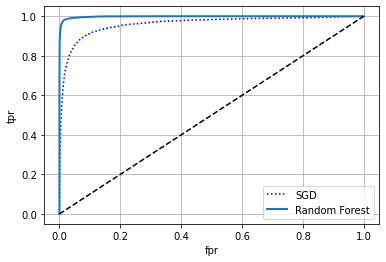

0.9983436731328145


In [42]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

#绘制对比图形

plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc = "lower right")
plt.show()

print(roc_auc_score(y_train_5, y_scores_forest))

In [59]:
# a是用RandomClassifier分类器分类出的结果矩阵
a = np.zeros((y_probas_forest.shape[0], 1), dtype = bool)
for i in range(y_probas_forest.shape[0]):
    if(y_probas_forest[i,0] < y_probas_forest[i, 1]):
        a[i] = True

In [60]:
#二元分类器，分类是否是5的混淆矩阵
confusion_matrix(y_train_5, a)

array([[54534,    45],
       [  725,  4696]], dtype=int64)

In [61]:
#随机森林分类器后结果的精度和召回率

print(precision_score(y_train_5, a))    # 4730 / (4730 + 49)

print(recall_score(y_train_5, a))     # 3530 / (4730 + 691)  

0.9905083315756169
0.8662608374838591


In [6]:
#试试SVM分类器，其实际训练45个二元分类器从而看起来实现多元分类器

from sklearn.svm import SVC

svm_clf = SVC()

svm_clf.fit(x_train_gz, y_train_gz)

svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [66]:
#调用decision_function()返回10个类分别的分数

some_digit_scores = svm_clf.decision_function([some_digit])

print(some_digit_scores)

print(np.argmax(some_digit_scores))

#目标类的列表

print(svm_clf.classes_)

[[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]
5
[0 1 2 3 4 5 6 7 8 9]


In [68]:
#如果想要强制Scikit-Learn使用一对一或者一对剩余策略，可以使用OneVsOneClassifier或OneVsRestClassifier类。只需要创建一个

#实例，然后将分类器传给其构造函数（它甚至不必是二元分类器）。例如，下面这段代码使用OvR策略，基于SVC创建了一个多类分类器：

from sklearn.multiclass import OneVsRestClassifier

# ovr_clf = OneVsRestClassifier(SVC())
# ovr_clf.fit(x_train_gz, y_train_gz)
# ovr_clf.predict([some_digit])

# print(len(ovr_clf.estimators_))

In [8]:
#训练SGDClassifier或者RandomForestClassifier同样简单：

sgd_clf.fit(x_train_gz, y_train_gz)

sgd_clf.predict([some_digit])

#这次sklearn不必实现0VR或者0V0，因为SGD分类器直接可以将实例分为多个类

#调用decision_function()获得分类器将每个实例分类为每个类的概率列表

sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [10]:
#评估这个分类器，使用交叉验证
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, x_train_gz, y_train_gz, cv = 3, scoring = "accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [12]:
#在所有的测试折叠上都超过了85%。如果是一个纯随机分类器，准确率大概是10%，所以这个结果不是太糟，但是依然有提升的空间。例

#如，将输入进行简单缩放可以将准确率提到89%以上：

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_gz.astype(np.float64))
cross_val_score(sgd_clf, x_train_scaled, y_train_gz, cv = 3, scoring = "accuracy")

array([0.8983, 0.891 , 0.9018])

In [15]:
#误差分析，假设你已经找到了一个有潜力的模型，现在你希望找到一些方法对其进一步改进。方法之一就是分析其错误类型。

#首先看看混淆矩阵。就像之前做的，使用cross_val_predict()函数进行预测，然后调用confusion_matrix（）函数：
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_pred = cross_val_predict(sgd_clf, x_train_scaled, y_train_gz, cv = 3)
conf_mx = confusion_matrix(y_train_gz, y_train_pred)
print(conf_mx)

[[5577    0   22    5    8   43   36    6  225    1]
 [   0 6400   37   24    4   44    4    7  212   10]
 [  27   27 5220   92   73   27   67   36  378   11]
 [  22   17  117 5227    2  203   27   40  403   73]
 [  12   14   41    9 5182   12   34   27  347  164]
 [  27   15   30  168   53 4444   75   14  535   60]
 [  30   15   42    3   44   97 5552    3  131    1]
 [  21   10   51   30   49   12    3 5684  195  210]
 [  17   63   48   86    3  126   25   10 5429   44]
 [  25   18   30   64  118   36    1  179  371 5107]]


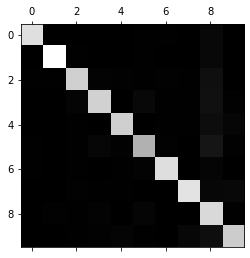

In [16]:
#使用Matplotlib的matshow（）函数来查看混淆矩阵的图像表示通常更加方便

plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

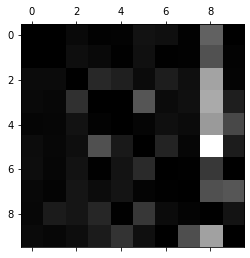

In [17]:
#首先，你需要将混淆矩阵中的每个值除以相应类中的图片数量，这样你比较的就是错误率而不是错误的绝对值（后者对图片数量较多的类不公平）：

# axis = 1是行，axis = 2是列
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

#用0填充对角线，只保留错误，重新绘制结果
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

In [18]:
#多标签分类
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train_gz >= 7)
y_train_odd = (y_train_gz % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train_gz, y_multilabel)

KNeighborsClassifier()

In [19]:
#拿第一张图片测试一下
knn_clf.predict([some_digit])

array([[False,  True]])

In [20]:
#简单计算下所有标签的平均F1分数
from sklearn.metrics import f1_score

y_train_knn_pred = cross_val_predict(knn_clf, x_train_gz, y_multilabel, cv = 3)
print(f1_score(y_multilabel, y_train_knn_pred, average = "macro"))
print(f1_score(y_multilabel, y_train_knn_pred, average = "weighted"))

0.976410265560605
0.9778357403921755


In [22]:
#多输出分类
#构造一个系统去除图片中的噪声，输入一张有噪声的土拍你，希望得到输出一个干净的图片
#以像素强度的一个数组作为呈现方式，这个分类器的输出是多个标签值，一个像素一个标签，每个标签可以有多个值（0 - 255）

noise = np.random.randint(0, 100, (len(x_train_gz), 784))
x_train_mod = x_train_gz + noise
noise = np.random.randint(0, 100, (len(x_test_gz), 784))
x_test_mod = x_test_gz + noise
y_train_mod = x_train_gz
y_test_mod = x_test_gz

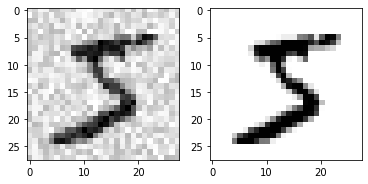

In [24]:
some_digit = x_train_mod[0]
some_digit_image = some_digit.reshape(28, 28)
plt.subplot(1,2,1)
plt.imshow(some_digit_image, cmap="binary")

some_digit = y_train_mod[0]
some_digit_image = some_digit.reshape(28, 28)
plt.subplot(1,2,2)
plt.imshow(some_digit_image, cmap="binary")

plt.axis("on")
plt.show()

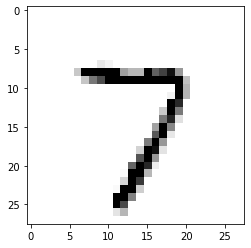

In [28]:
#训练knn多标签分类器，清洗这张图片
knn_clf.fit(x_train_mod, y_train_mod)
clean_digit = knn_clf.predict([x_test_mod[0]])
plt.imshow(clean_digit.reshape(28, 28), cmap="binary")

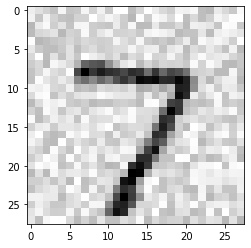

In [32]:
plt.imshow(x_test_mod[0].reshape(28, 28), cmap = "binary")